In [7]:
# esn_char_predict.py
# Echo State Network for next-character prediction on tinyshakespear.txt
# - Chronological train/test split
# - Online RLS readout training (memory efficient)
# - Reports test accuracy and plots training loss over time

import argparse
import numpy as np
import matplotlib.pyplot as plt

def build_vocab(text):
    chars = sorted(list(set(text)))
    stoi = {ch: i for i, ch in enumerate(chars)}
    itos = {i: ch for ch, i in stoi.items()}
    return chars, stoi, itos

def text_to_indices(text, stoi):
    return np.array([stoi[ch] for ch in text], dtype=np.int32)

def init_reservoir(n_in, n_res, density, spectral_radius, input_scale, seed):
    rng = np.random.default_rng(seed)
    # Input weights include bias; shape: n_res x (1 + n_in)
    Win = (rng.standard_normal((n_res, 1 + n_in)).astype(np.float32)) * input_scale
    # Reservoir weights sparse-ish dense matrix
    W = np.zeros((n_res, n_res), dtype=np.float32)
    nnz = int(density * n_res * n_res)
    idx_i = rng.integers(0, n_res, size=nnz)
    idx_j = rng.integers(0, n_res, size=nnz)
    vals = rng.standard_normal(nnz).astype(np.float32)
    W[idx_i, idx_j] = vals
    # Scale to desired spectral radius
    eigvals = np.linalg.eigvals(W.astype(np.float64))
    sr = np.max(np.abs(eigvals)).real
    if sr > 0:
        W *= (spectral_radius / sr)
    return Win, W

def rls_init(n_feat, reg):
    # P ~ (1/reg) * I; larger 1/reg means weaker prior (more plastic)
    P = (1.0 / reg) * np.eye(n_feat, dtype=np.float32)
    return P

def run_esn_training(
    indices,
    vocab_size,
    Win, W,
    alpha=0.3,
    washout=100,
    reg=1.0,
    loss_chunk=1000,
    include_input_in_readout=True,
    seed=42,
):
    rng = np.random.default_rng(seed)
    n_res = W.shape[0]
    n_in = vocab_size
    n_out = vocab_size

    # One-hot lookup
    I = np.eye(vocab_size, dtype=np.float32)

    # Reservoir state
    x = np.zeros(n_res, dtype=np.float32)

    # Feature vector z = [1, u, x] or [1, x]
    if include_input_in_readout:
        n_feat = 1 + n_in + n_res
    else:
        n_feat = 1 + n_res

    # Readout
    Wout = np.zeros((n_out, n_feat), dtype=np.float32)

    # RLS inverse correlation matrix
    P = rls_init(n_feat, reg=reg)

    # Loss tracking
    losses = []
    chunk_losses = []
    steps_seen = 0

    # Training loop (teacher forcing), using all pairs (t -> t+1) after washout
    # We will update P and Wout only after washout
    T = len(indices) - 1
    bias = np.array([1.0], dtype=np.float32)

    for t in range(T):
        u_idx = indices[t]
        v_idx = indices[t + 1]

        u = I[u_idx]  # one-hot current
        v = I[v_idx]  # one-hot next

        # Reservoir update: x <- (1 - alpha) * x + alpha * tanh( Win @ [1; u] + W @ x )
        in_vec = np.concatenate([bias, u], dtype=np.float32)  # shape 1 + n_in
        preact = Win @ in_vec + W @ x
        x = (1.0 - alpha) * x + alpha * np.tanh(preact)

        # Feature vector
        if include_input_in_readout:
            z = np.concatenate([bias, u, x], dtype=np.float32)  # shape n_feat
        else:
            z = np.concatenate([bias, x], dtype=np.float32)

        # Predict
        y_pred = Wout @ z  # linear logits for each char

        # Compute MSE loss vs one-hot target
        err = v - y_pred
        mse = np.mean(err * err)
        # During washout, just track reservoir settling; no RLS updates
        if t >= washout:
            # RLS update
            # k = P z / (1 + z^T P z)
            Pz = P @ z
            denom = 1.0 + float(z @ Pz)
            k = Pz / denom  # shape (n_feat,)

            # Wout <- Wout + (v - y_pred) k^T
            # Broadcasting outer product for multi-output
            Wout += np.outer(err, k).astype(np.float32)

            # P <- P - k (z^T P)
            P -= np.outer(k, Pz).astype(np.float32)

            # record loss
            chunk_losses.append(mse)
            steps_seen += 1
            if steps_seen % loss_chunk == 0:
                losses.append(float(np.mean(chunk_losses)))
                chunk_losses = []

    # If last partial chunk exists, record it
    if len(chunk_losses) > 0:
        losses.append(float(np.mean(chunk_losses)))

    return Wout, losses

def evaluate_accuracy(indices, vocab_size, Win, W, Wout, alpha=0.3, include_input_in_readout=True):
    # Teacher forcing evaluation: predict next char from current char and current state
    n_res = W.shape[0]
    I = np.eye(vocab_size, dtype=np.float32)
    x = np.zeros(n_res, dtype=np.float32)
    bias = np.array([1.0], dtype=np.float32)
    correct = 0
    total = 0
    T = len(indices) - 1
    for t in range(T):
        u_idx = indices[t]
        v_idx = indices[t + 1]
        u = I[u_idx]

        in_vec = np.concatenate([bias, u], dtype=np.float32)
        preact = Win @ in_vec + W @ x
        x = (1.0 - alpha) * x + alpha * np.tanh(preact)

        if include_input_in_readout:
            z = np.concatenate([bias, u, x], dtype=np.float32)
        else:
            z = np.concatenate([bias, x], dtype=np.float32)

        y_pred = Wout @ z
        pred_idx = int(np.argmax(y_pred))
        correct += (pred_idx == v_idx)
        total += 1
    acc = correct / total if total > 0 else 0.0
    return acc

def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--path", type=str, default="tinyshakespeare.txt", help="Path to text file")
    parser.add_argument("--train_ratio", type=float, default=0.9, help="Chronological train split ratio")
    parser.add_argument("--n_res", type=int, default=300, help="Reservoir size")
    parser.add_argument("--density", type=float, default=0.05, help="Reservoir connection density in [0,1]")
    parser.add_argument("--spectral_radius", type=float, default=0.9, help="Reservoir spectral radius")
    parser.add_argument("--alpha", type=float, default=0.3, help="Leaking rate")
    parser.add_argument("--input_scale", type=float, default=1.0, help="Scale for input weights")
    parser.add_argument("--reg", type=float, default=1.0, help="RLS regularization (P0 = I/reg)")
    parser.add_argument("--washout", type=int, default=100, help="Washout steps during training")
    parser.add_argument("--loss_chunk", type=int, default=2000, help="Steps per averaged loss point")
    parser.add_argument("--include_input", action="store_true", help="Include direct input-to-readout in features")
    parser.add_argument("--seed", type=int, default=42, help="Random seed")
    args = parser.parse_args()

    # Load text
    with open(args.path, "r", encoding="utf-8") as f:
        text = f.read()

    # Build vocab and indices
    chars, stoi, itos = build_vocab(text)
    data = text_to_indices(text, stoi)
    vocab_size = len(chars)
    N = len(data)

    # Chronological split
    split = int(args.train_ratio * N)
    train_idx = data[:split]
    test_idx  = data[split:]

    print(f"Text length: {N}, Vocab size: {vocab_size}")
    print(f"Train steps: {len(train_idx)-1}, Test steps: {len(test_idx)-1}")

    # Initialize reservoir
    Win, W = init_reservoir(
        n_in=vocab_size,
        n_res=args.n_res,
        density=args.density,
        spectral_radius=args.spectral_radius,
        input_scale=args.input_scale,
        seed=args.seed,
    )

    # Train (RLS online)
    Wout, losses = run_esn_training(
        train_idx,
        vocab_size,
        Win, W,
        alpha=args.alpha,
        washout=args.washout,
        reg=args.reg,
        loss_chunk=args.loss_chunk,
        include_input_in_readout=args.include_input,
        seed=args.seed,
    )

    # Evaluate accuracy on test set
    test_acc = evaluate_accuracy(
        test_idx,
        vocab_size,
        Win, W, Wout,
        alpha=args.alpha,
        include_input_in_readout=args.include_input,
    )

    print(f"Test accuracy (next-char, teacher forcing): {test_acc:.4f}")

    # Plot training loss
    plt.figure(figsize=(8,4))
    xs = np.arange(1, len(losses)+1) * args.loss_chunk
    plt.plot(xs, losses, label="Training MSE (avg per chunk)")
    plt.xlabel("Training steps")
    plt.ylabel("MSE")
    plt.title("ESN Readout Online Training Loss (RLS)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig("training_loss.png", dpi=150)
    try:
        plt.show()
    except Exception:
        pass

# Modified for Jupyter notebook execution
def main_jupyter():
    # Set parameters directly instead of using argparse
    params = {
        "path": "tinyshakespeare.txt",  # Make sure this file exists
        "train_ratio": 0.9,
        "n_res": 300,
        "density": 0.05,
        "spectral_radius": 0.9,
        "alpha": 0.3,
        "input_scale": 1.0,
        "reg": 1.0,
        "washout": 100,
        "loss_chunk": 2000,
        "include_input": True,
        "seed": 42
    }
    
    # Rest of the main function code with args replaced by params dict
    # Load text
    try:
        with open(params["path"], "r", encoding="utf-8") as f:
            text = f.read()
    except FileNotFoundError:
        print(f"Error: File {params['path']} not found!")
        return
    
    # Build vocab and indices
    chars, stoi, itos = build_vocab(text)
    data = text_to_indices(text, stoi)
    vocab_size = len(chars)
    N = len(data)

    # ... rest of the function remains the same, replace args. with params[]

    # Chronological split
    split = int(params["train_ratio"] * N)
    train_idx = data[:split]
    test_idx  = data[split:]

    print(f"Text length: {N}, Vocab size: {vocab_size}")
    print(f"Train steps: {len(train_idx)-1}, Test steps: {len(test_idx)-1}")

    # Initialize reservoir
    Win, W = init_reservoir(
        n_in=vocab_size,
        n_res=params["n_res"],
        density=params["density"],
        spectral_radius=params["spectral_radius"],
        input_scale=params["input_scale"],
        seed=params["seed"],
    )

    # Train (RLS online)
    Wout, losses = run_esn_training(
        train_idx,
        vocab_size,
        Win, W,
        alpha=params["alpha"],
        washout=params["washout"],
        reg=params["reg"],
        loss_chunk=params["loss_chunk"],
        include_input_in_readout=params["include_input"],
        seed=params["seed"],
    )

    # Evaluate accuracy on test set
    test_acc = evaluate_accuracy(
        test_idx,
        vocab_size,
        Win, W, Wout,
        alpha=params["alpha"],
        include_input_in_readout=params["include_input"],
    )

    print(f"Test accuracy (next-char, teacher forcing): {test_acc:.4f}")

    # Plot training loss
    plt.figure(figsize=(8,4))
    xs = np.arange(1, len(losses)+1) * params["loss_chunk"]
    plt.plot(xs, losses, label="Training MSE (avg per chunk)")
    plt.xlabel("Training steps")
    plt.ylabel("MSE")
    plt.title("ESN Readout Online Training Loss (RLS)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig("training_loss.png", dpi=150)
    try:
        plt.show()
    except Exception:
        pass


Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3453


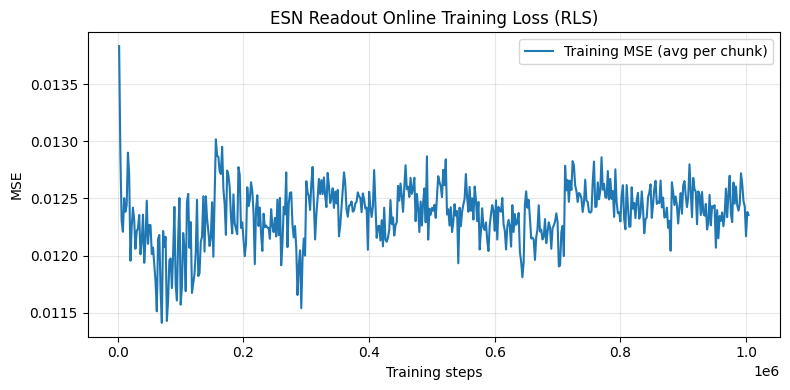

In [8]:
main_jupyter()